# Install Dependecies


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [ ]:
from datasets import Dataset,load_dataset
from google.colab import drive
from transformers import AutoImageProcessor, Dinov2Model
import torch
import os
import shutil
from PIL import Image
import torchvision.transforms as T
from tqdm.auto import tqdm
import numpy as np
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
extractor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = Dinov2Model.from_pretrained("facebook/dinov2-base")
hidden_dim = model.config.hidden_size

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

# Perpare the Images
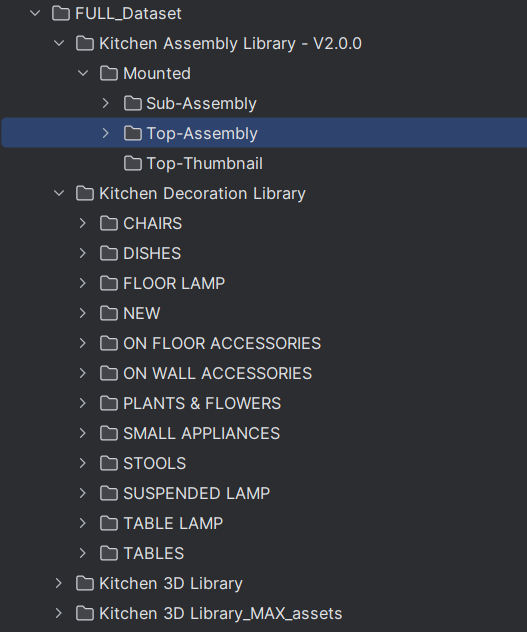

the code below extract all the images and put them in 1 level deep dircetory where each image will be named according to the full path to the image

In [ ]:
def copy_images(source_dir, destination_dir, image_extensions=(".jpg", ".jpeg", ".png", ".bmp", ".gif")):
    """
    Searches recursively through nested folders in the source directory,
    identifies files with specified image extensions, and copies them to
    the destination directory.

    Args/
        source_dir (str)/ Path to the directory containing nested folders.
        destination_dir (str)/ Path to the destination directory for images.
        image_extensions (tuple, optional)/ A tuple of image file extensions to search for.
            Defaults to (".jpg", ".jpeg", ".png", ".bmp", ".gif").
    """
    index = 1
    for root, dirs, files in os.walk(source_dir):
        for filename in files:
            # Check for image extensions
            if filename.lower().endswith(image_extensions):

                source_path = os.path.join(root, filename)
                source_path = os.path.join(root, filename)
                source_path.replace("\\", "/")
                source_path.replace("\\\\", "/")
                name="---".join(source_path.split("/")[1:])
                print(name)
                # Generate a unique filename with an index to avoid overwriting
                new_filename, extension = os.path.splitext(filename)
                #print(new_filename, extension)
                """while os.path.exists(os.path.join(destination_dir, new_filename + extension)):

                    new_filename = f"{new_filename}_{index}_{dirs}"
                    index += 1
                new_filename=name"""
                destination_path = destination_dir+"/"+name

                try:
                    # Copy the file
                    shutil.copy2(source_path, destination_path)
                    print(f"Copied image/ {source_path} -> {destination_path}")
                except (shutil.Error, FileNotFoundError) as e:
                    print(f"Error copying image/ {source_path} - {e}")

if __name__ == "__main__":
    source_dir = "/content/drive/MyDrive/TASK_3_Dataset"  # Replace with your source directory path
    destination_dir = "./FULL_Dataset_images"  # Replace with your destination directory path

    copy_images(source_dir, destination_dir)


In [ ]:
# prompt: delefe a folder in colab

!rm -rf FULL_Dataset_images


The below fucntion is to convert all the image sinto 1 specific fomrat whihc is RGB

In [ ]:
# Define the path to the folder containing images
folder_path = 'C:/Users/HHR6/PycharmProjects/Task3/FULL_Dataset_images'

# Loop over all files in the folder
for filename in os.listdir(folder_path):
    # Construct the full file path
    file_path = os.path.join(folder_path, filename)

    # Open the image file
    i=0
    with Image.open(file_path) as img:
        # Convert the image to RGB mode
        rgb_img = img.convert('RGB')
        # Save the image back to the folder (you can overwrite or create a new filename)
        # To overwrite:
        rgb_img.save(file_path)

        # Or to save with a new name, for example appending '_rgb':
        # new_file_path = os.path.join(folder_path, f"{os.path.splitext(filename)[0]}_rgb{os.path.splitext(filename)[1]}")
        # rgb_img.save(new_file_path)


# Create A dataset

Then we Create a Dataset Variable where each in the Dataset contain the Image and the image path or the name of the image and also it could contain a lable here the label has no usecase since all image will be labeled 0

In [ ]:
folder_path = 'C:/Users/HHR6/PycharmProjects/Task3/FULL_Dataset_images'
dataset=[]
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    with Image.open(file_path) as img:
        dataset.append({"image_path": filename, "image": img, "label": 0})
print(len(dataset))
from datasets import Dataset
Dataset= Dataset.from_list(dataset)
Dataset.save_to_disk("my_dataset")


Here we load the Datataset from the saved file

In [ ]:
# Load the dataset from Arrow files
Dataset = load_dataset("arrow", data_files="/content/drive/MyDrive/my_dataset/data-00000-of-00001.arrow")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
Dataset

DatasetDict({
    train: Dataset({
        features: ['image_path', 'image', 'label'],
        num_rows: 4992
    })
})

In [ ]:
Dataset=Dataset["train"]

In [ ]:
Dataset[1]

{'image_path': 'Kitchen 3D Library---Appliances---cooktop---EU_cooktop_electric_2-burners---EU_cooktop_electric_2-burners_1---EU_cooktop_electric_2-burners_1_ambiant.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 0}

Here we have shuffled the Dataset

In [ ]:
num_samples = 4992
seed = 42
candidate_subset = Dataset.shuffle(seed=seed).select(range(num_samples))

# Get The Embeddings

Here we need to create a transformation Pipeline this will make sure that all images are consistent  

In [ ]:
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["shortest_edge"])),
        T.CenterCrop(extractor.size["shortest_edge"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

Then we use the extract embedding to define a map function that will be applied to our dataset of images

In [ ]:
def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        print(batch)
        images = batch["image"]
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        # print(image_batch_transformed.shape)
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state.cpu()
        return {"embeddings": embeddings.mean(dim=1)}

    return pp


# Here, we map embedding extraction utility on our subset of candidate images.
batch_size = 24
device = "cuda" if torch.cuda.is_available() else "cpu"


Running the below function will get the EMbeddings to all our datatset

In [ ]:
extract_fn = extract_embeddings(model.to(device))
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=13)

Map:   0%|          | 0/4992 [00:00<?, ? examples/s]

{'image_path': ['Kitchen 3D Library---Appliances---cooktop---EU_cooktop_gas_4-burners---EU_cooktop_gas_4-burners_19---EU_cooktop_gas_4-burners_19_v512.jpg', 'Kitchen Decoration Library---ON FLOOR ACCESSORIES---20_WINE RACK---20_WINE RACK.jpg', 'Kitchen 3D Library---Appliance_old---hood---US_worktop_hood---US_worktop_hood_4---US_worktop_hood_4_v512.jpg', 'Kitchen 3D Library---Front---front_sculpted---front_sculpted_8---front_sculpted_drawer_8_01_v512.jpg', 'Kitchen 3D Library---Sanitary---sink---standard---sink_standard_2-bowls_without_drainer---sink_standard_2-bowls_without_drainer_4---sink_standard_2-bowls_without_drainer_4_v512.jpg', 'Kitchen 3D Library---Appliance_old---cooktop---US_cooktop_gas_6-burners---US_cooktop_gas_6-burners_1---US_cooktop_gas_6-burners_1_v512.jpg', 'Kitchen 3D Library---construction interieur---divers---coffre_fort---coffre_fort_02---coffre_fort_02_v512.jpg', 'Kitchen 3D Library---Appliance_old---cooktop---EU_cooktop_induction_3-burners---EU_cooktop_induction

The we create a List that cintain the images path to all the datatset to be able to idnetify the most similar vectors

In [ ]:
candidate_ids = []

for id in tqdm(range(len(candidate_subset_emb))):
    label = candidate_subset_emb[id]["image_path"]

    # Create a unique indentifier.
    entry = str(id) + "_" + str(label)

    candidate_ids.append(entry)

  0%|          | 0/4992 [00:00<?, ?it/s]

In [ ]:
with open('my_list.txt', 'w') as file:
    for item in candidate_ids:
        file.write("%s\n" % item)

In [ ]:
loaded_list = []
with open('/content/my_list.txt', 'r') as file:
    for line in file:
        # Convert each line to the appropriate data type (e.g., integer, string)
        # Assuming the list originally had integers and strings only
        line = line.strip()
        if line.isdigit():
            loaded_list.append(int(line))
        else:
            loaded_list.append(line)

print(loaded_list)

['0_Kitchen 3D Library---Appliances---cooktop---EU_cooktop_gas_4-burners---EU_cooktop_gas_4-burners_19---EU_cooktop_gas_4-burners_19_v512.jpg', '1_Kitchen Decoration Library---ON FLOOR ACCESSORIES---20_WINE RACK---20_WINE RACK.jpg', '2_Kitchen 3D Library---Appliance_old---hood---US_worktop_hood---US_worktop_hood_4---US_worktop_hood_4_v512.jpg', '3_Kitchen 3D Library---Front---front_sculpted---front_sculpted_8---front_sculpted_drawer_8_01_v512.jpg', '4_Kitchen 3D Library---Sanitary---sink---standard---sink_standard_2-bowls_without_drainer---sink_standard_2-bowls_without_drainer_4---sink_standard_2-bowls_without_drainer_4_v512.jpg', '5_Kitchen 3D Library---Appliance_old---cooktop---US_cooktop_gas_6-burners---US_cooktop_gas_6-burners_1---US_cooktop_gas_6-burners_1_v512.jpg', '6_Kitchen 3D Library---construction interieur---divers---coffre_fort---coffre_fort_02---coffre_fort_02_v512.jpg', '7_Kitchen 3D Library---Appliance_old---cooktop---EU_cooktop_induction_3-burners---EU_cooktop_inductio

In [ ]:
len(candidate_subset_emb["embeddings"])

4992

In [ ]:
all_candidate_embeddings_1 = np.array(candidate_subset_emb["embeddings"])

In [ ]:
type(all_candidate_embeddings_1)
print("The given array is:",all_candidate_embeddings_1)
print("The size of array arr is:",all_candidate_embeddings_1.size)
print("The memorysize of each element of arr is:", all_candidate_embeddings_1.itemsize,"bytes")
print("The memory size of numpy array arr is:",all_candidate_embeddings_1.itemsize*all_candidate_embeddings_1.size,"bytes")

The given array is: [[-0.56104839 -0.53710371  1.84270191 ... -1.36686349  0.93835759
  -0.84713024]
 [-0.1601921   1.18905389  0.69289708 ... -0.56628317 -0.75692749
  -0.40047473]
 [-0.00421697 -0.11432674  0.32809117 ...  1.18239498 -0.67594457
  -0.56845325]
 ...
 [ 0.06492896 -0.84565043  0.39339545 ... -0.79969501  0.67634559
  -0.18493472]
 [ 1.44349241  0.94722235  0.25748691 ... -1.40949261 -0.9271633
   0.35868376]
 [ 0.56744623  0.77457452  0.77857542 ... -0.26841056 -1.62678599
   0.99919826]]
The size of array arr is: 3833856
The memorysize of each element of arr is: 8 bytes
The memory size of numpy array arr is: 30670848 bytes


Save the mebdding as a npy array

In [ ]:
# all_candidate_embeddings_1.tofile('test2.dat')
# Save to a file named "my_array.npy" in your Colab Drive (mount required)
np.save('/content/drive/MyDrive/Dataset.npy', all_candidate_embeddings_1)

load the saved npy file in torch data type

In [ ]:
loaded_array = np.load('/content/drive/MyDrive/Dataset.npy')

In [ ]:
all_candidate_embeddings = torch.from_numpy(loaded_array)

# Functionality

the below function get the similrity between two embedding vector

In [ ]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    emb_one=emb_one
    emb_two=emb_two
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


In [ ]:
def fetch_similar(image, top_k=20):
    """Fetches the `top_k` similar images with `image` as the query."""
    # Prepare the input query image for embedding computation.
    image_transformed = transformation_chain(image).unsqueeze(0)


    new_batch = {"pixel_values": image_transformed.to(device)}

    # Comute the embedding.
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state.cpu()
        query_embeddings=query_embeddings.mean(dim=1)

        print((query_embeddings.shape))
    # Compute similarity scores with all the candidate images at one go.
    # We also create a mapping between the candidate image identifiers
    # and their similarity scores with the query image.
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(loaded_list, sim_scores))

    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x: str(x), id_entries))
    return ids, labels

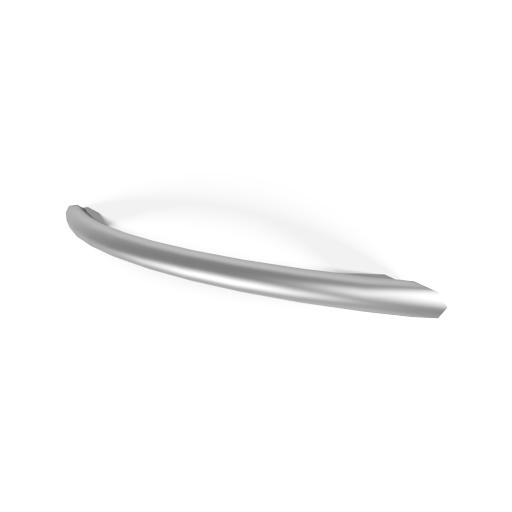

In [ ]:
test_idx = np.random.choice(len(Dataset))
test_sample = Dataset[test_idx]["image"]
test_label = Dataset[test_idx]["label"]
test_sample


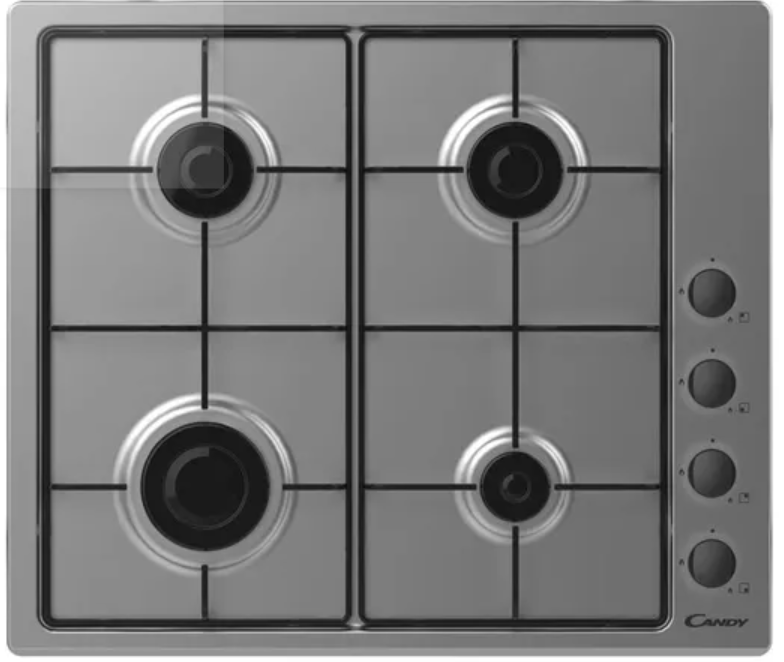

In [ ]:
from PIL import Image
test_sample=Image.open("/content/TABLES DE CUISSON_12.png").convert('RGB')
test_sample

In [ ]:
sim_ids, sim_labels = fetch_similar(test_sample)
print(f"Query label: {test_label}")
print(f"Top 5 candidate labels: {sim_labels}")

torch.Size([1, 768])
Query label: 0
Top 5 candidate labels: ['1030_Kitchen 3D Library---Appliances---cooktop---EU_cooktop_gas_4-burners---EU_cooktop_gas_4-burners_5---EU_cooktop_gas_4-burners_5_vold.png', '3386_Kitchen 3D Library---Appliance_old---cooktop---EU_cooktop_gas_4-burners---EU_cooktop_gas_4-burners_5---EU_cooktop_gas_4-burners_5_vold.png', '2098_Kitchen 3D Library---Appliance_old---cooktop---EU_cooktop_gas_4-burners---EU_cooktop_gas_4-burners_10---EU_cooktop_gas_4-burners_10_vold.png', '4931_Kitchen 3D Library---Appliances---cooktop---EU_cooktop_gas_4-burners---EU_cooktop_gas_4-burners_10---EU_cooktop_gas_4-burners_10_vold.png', '725_Kitchen 3D Library---Appliances---cooktop---EU_cooktop_gas_4-burners---EU_cooktop_gas_4-burners_23---EU_cooktop_gas_4-burners_23_vold.png', '1579_Kitchen 3D Library---Appliance_old---cooktop---EU_cooktop_gas_4-burners---EU_cooktop_gas_4-burners_23---EU_cooktop_gas_4-burners_23_vold.png', '3996_Kitchen 3D Library---Appliance_old---cooktop---EU_coo

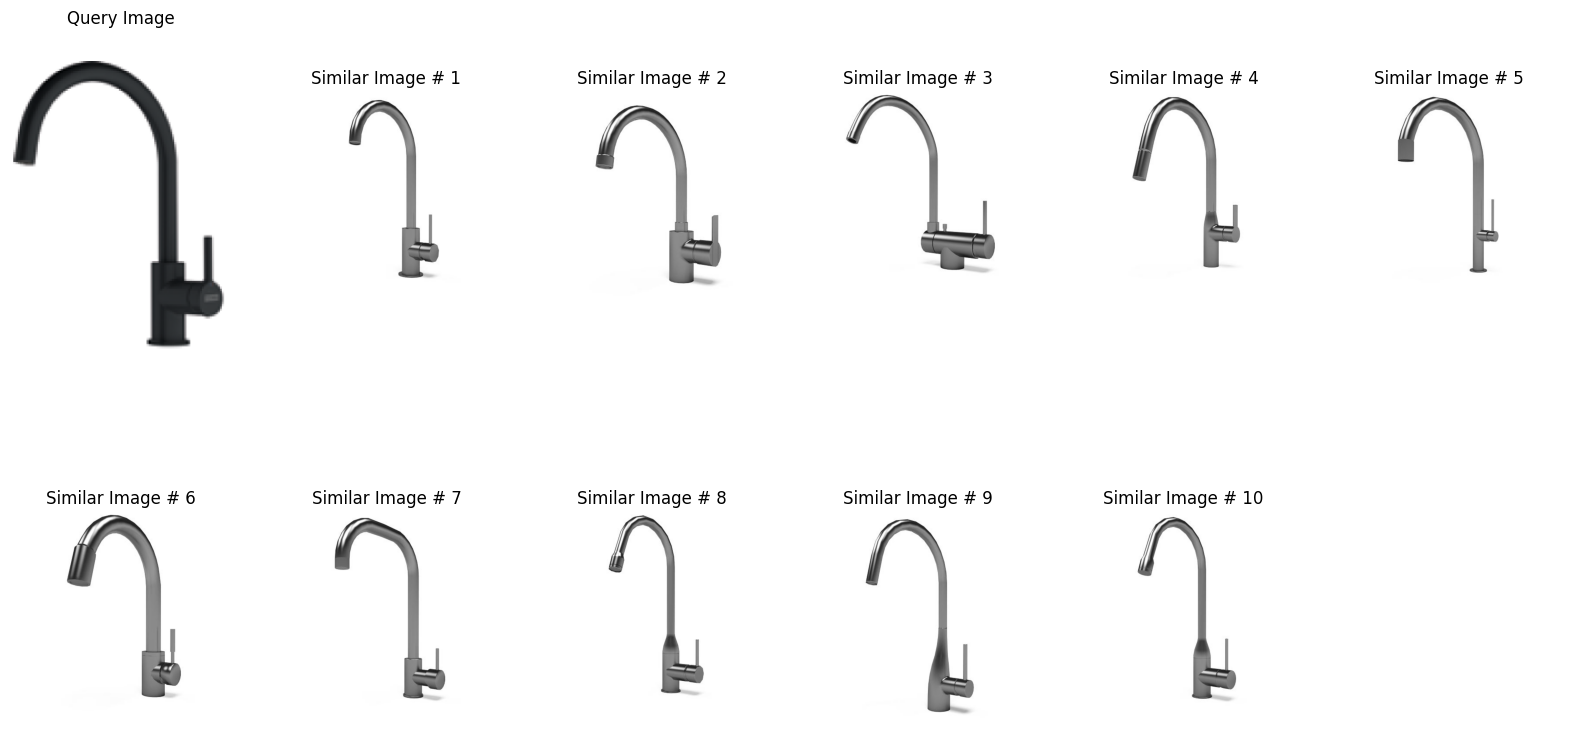

In [ ]:
import matplotlib.pyplot as plt


def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
             ax.set_title("Query Image\n")
        else:
             ax.set_title("Similar Image # " + str(i) )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset[id]["image"])
    labels.append(candidate_subset[id]["label"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)

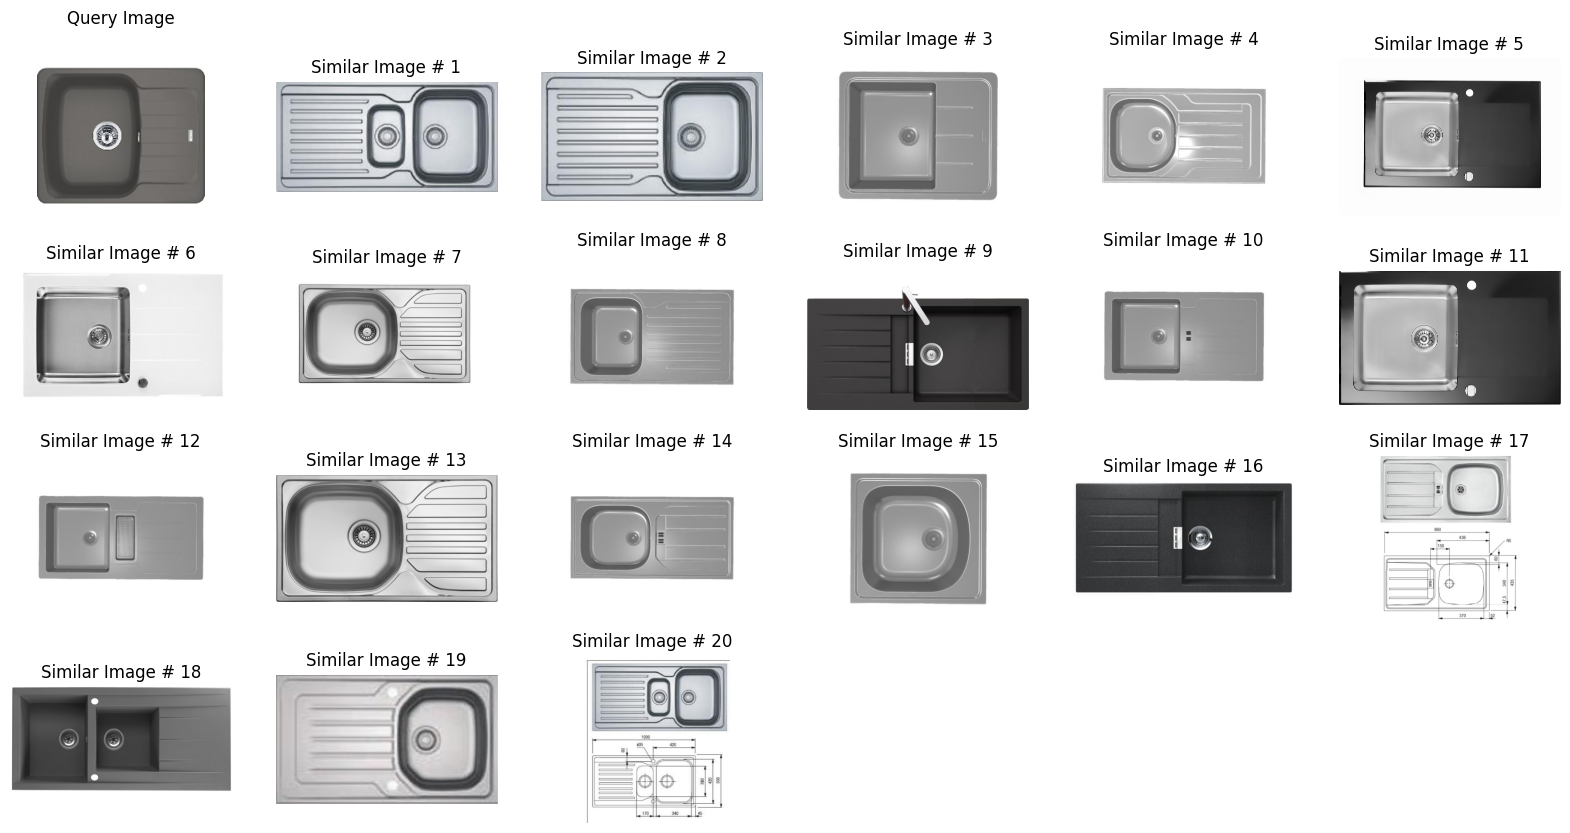

In [ ]:
import matplotlib.pyplot as plt


def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
             ax.set_title("Query Image\n")
        else:
             ax.set_title("Similar Image # " + str(i) )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset[id]["image"])
    labels.append(candidate_subset[id]["label"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)

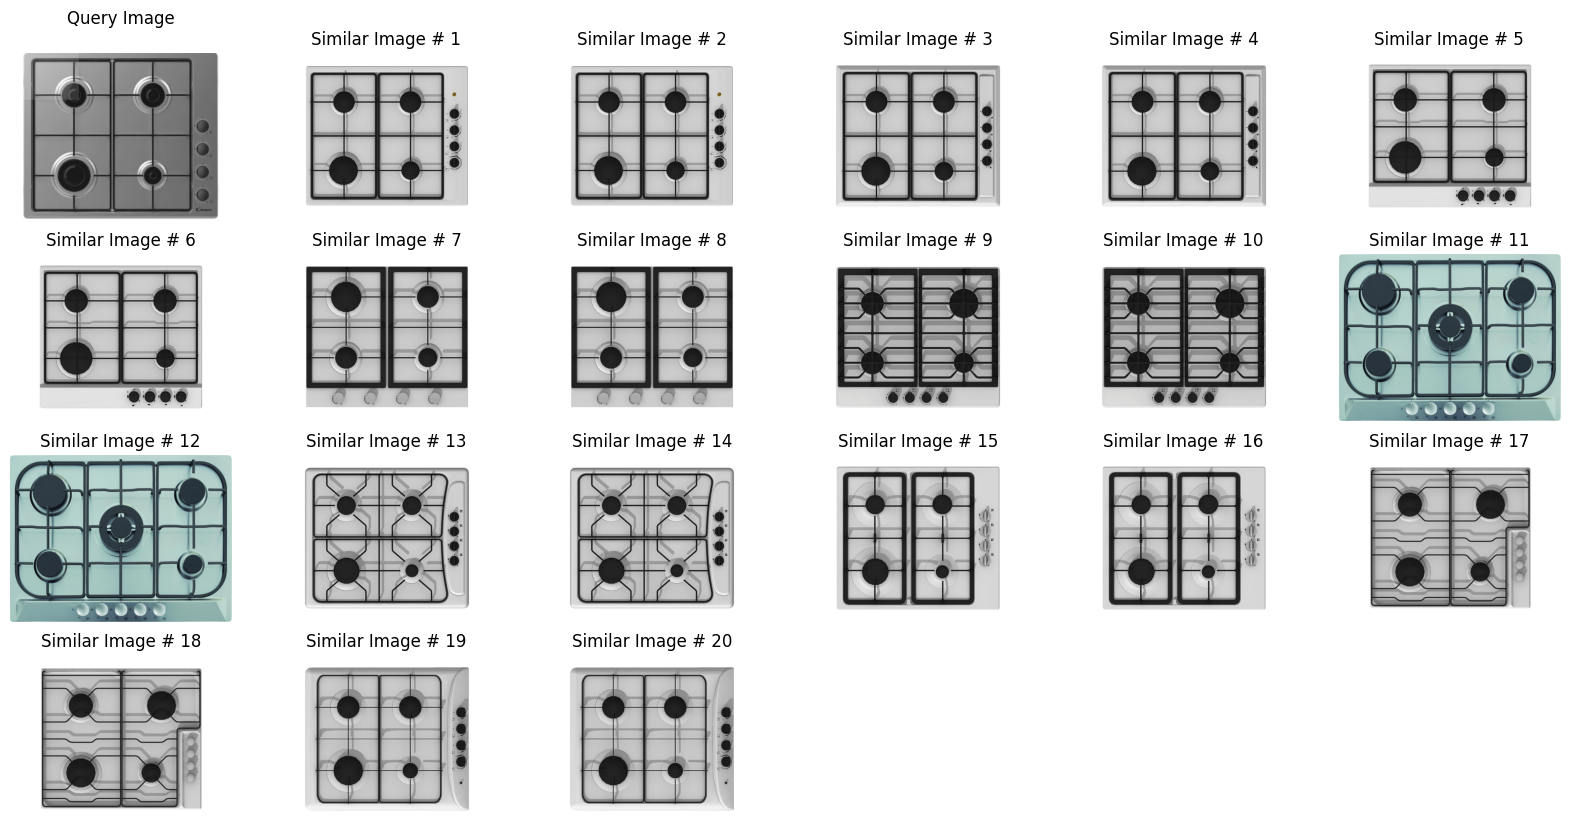

In [ ]:
import matplotlib.pyplot as plt


def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
             ax.set_title("Query Image\n")
        else:
             ax.set_title("Similar Image # " + str(i) )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset[id]["image"])
    labels.append(candidate_subset[id]["label"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)

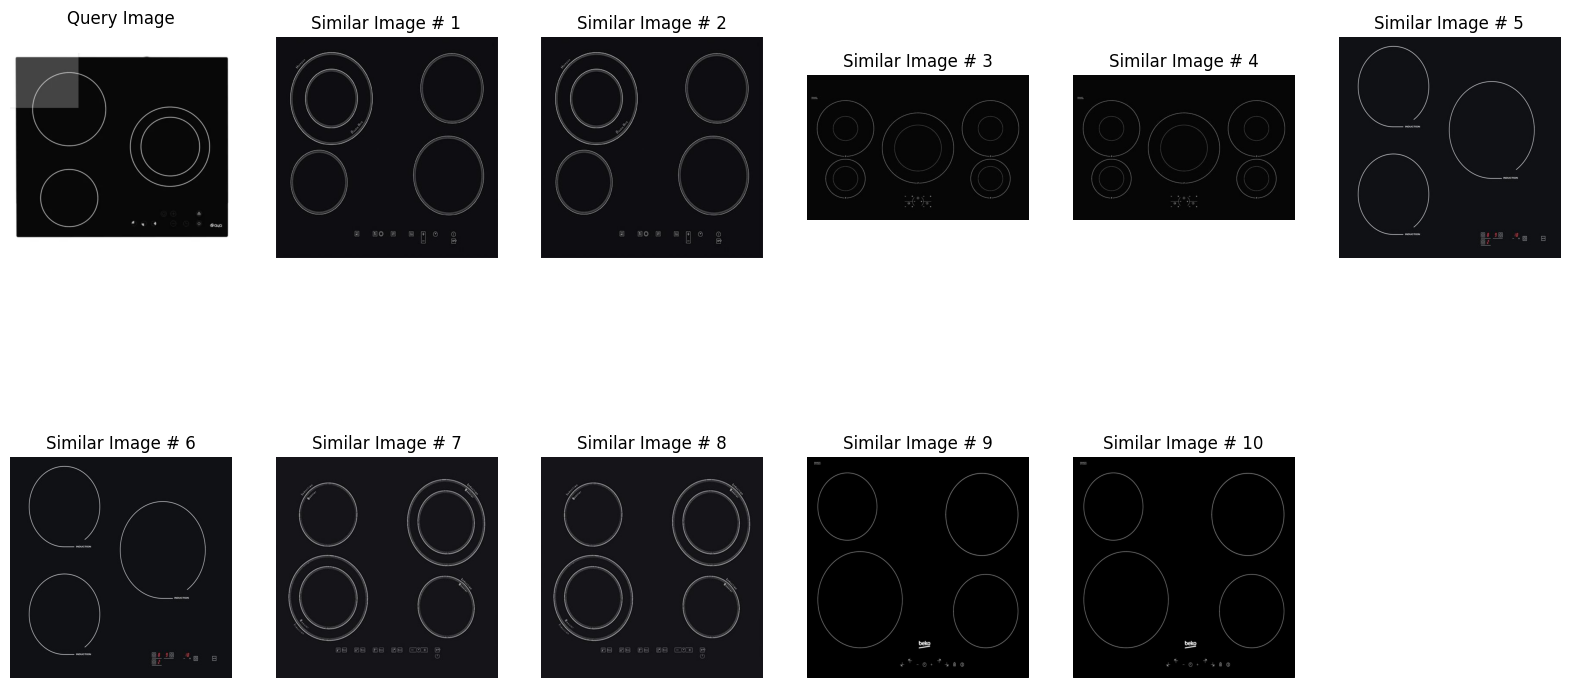

In [ ]:
import matplotlib.pyplot as plt


def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
             ax.set_title("Query Image\n")
        else:
             ax.set_title("Similar Image # " + str(i) )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset[id]["image"])
    labels.append(candidate_subset[id]["label"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)